In [10]:
import pandas as pd
from pandas import Series
import nltk
import string
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk import ngrams

import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn import cluster

import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score

In [29]:
#Read tokenized and rooted sentences.
textdata = pd.read_csv('rooted12.csv')

In [3]:
textdata

,Unnamed: 0,accession#,label,Clean
0,51202,0001193125-14-166451,active investor risk,"['fund', 'permit', 'shortterm', 'trading', 'se..."
1,440048,0001193125-17-354253,active investor risk,"['fund', 'permit', 'shortterm', 'trading', 'se..."
2,310977,0001193125-16-780619,active investor risk,"['fund', 'permit', 'shortterm', 'trading', 'se..."
3,311109,0001193125-16-780634,active investor risk,"['fund', 'permit', 'shortterm', 'trading', 'se..."
4,490693,0001039803-18-000174,active investor risk,"['fund', 'permit', 'shortterm', 'trading', 'se..."
...,...,...,...,...
119995,28547,0001133228-14-002112,warrants risk,"['warrant', 'right', 'purchase', 'security', '..."
119996,375432,0001133228-17-007084,warrants risk,"['price', 'warrant', 'may', 'precisely', 'refl..."
119997,503088,0001104659-18-074152,warrants risk,"['warrant', 'instrument', 'entitle', 'holder',..."
119998,47719,0001193125-14-110643,warrants risk,"['price', 'underlying', 'stock', 'rise', 'exer..."


In [4]:
#Run the vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(textdata['Clean'])
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)



120000 rows


,0,1,2,3,4,5,6,7,8,9,...,119990,119991,119992,119993,119994,119995,119996,119997,119998,119999
ratio,0.279921,0.279921,0.279921,0.279921,0.279921,0.252464,0.277255,0.252282,0.279921,0.279921,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
trading,0.256959,0.256959,0.256959,0.256959,0.256959,0.231755,0.254512,0.231588,0.256959,0.256959,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fund,0.212008,0.212008,0.212008,0.212008,0.212008,0.223081,0.209989,0.222920,0.212008,0.212008,...,0.032968,0.197176,0.098513,0.176882,0.098513,0.198816,0.178287,0.123412,0.081637,0.197176
asset,0.202057,0.202057,0.202057,0.202057,0.202057,0.182238,0.200133,0.182106,0.202057,0.202057,...,0.000000,0.086733,0.000000,0.091953,0.000000,0.087454,0.000000,0.000000,0.000000,0.086733
strategiesthese,0.176008,0.176008,0.176008,0.176008,0.176008,0.158744,0.174332,0.158630,0.176008,0.176008,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
def run_KMeans(max_k, data):
    kmeans = cluster.KMeans(n_clusters = max_k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')
    kmeans.fit(data)
    return kmeans

In [24]:
#Run k-means with 15 clusters on training dataframe
k = 15
kmeans = run_KMeans(k, train_df)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [25]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

In [26]:
#Predict the labels for both the training and testing data.
final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)

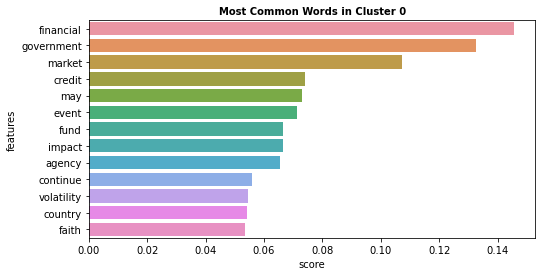

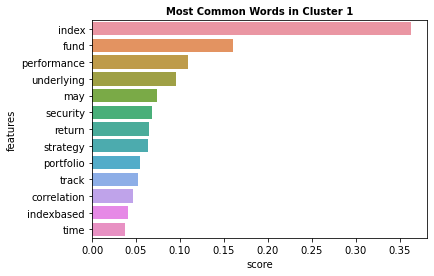

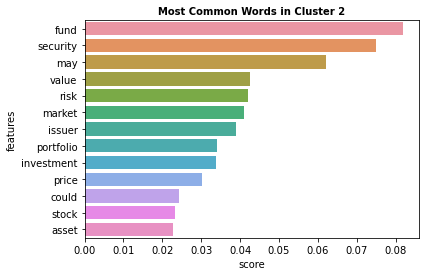

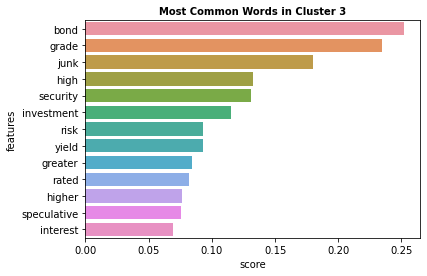

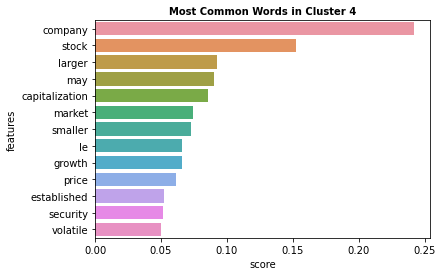

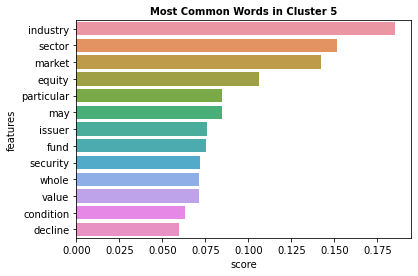

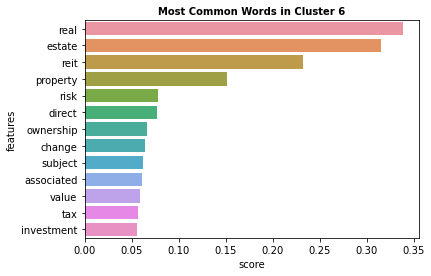

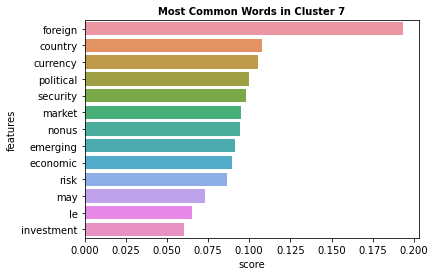

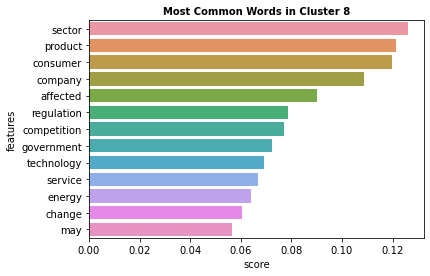

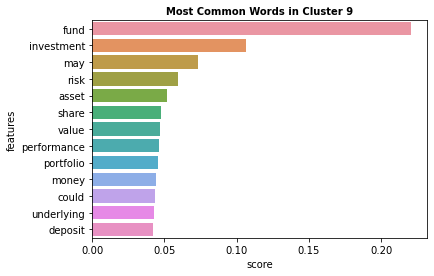

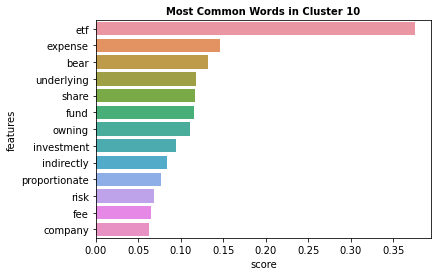

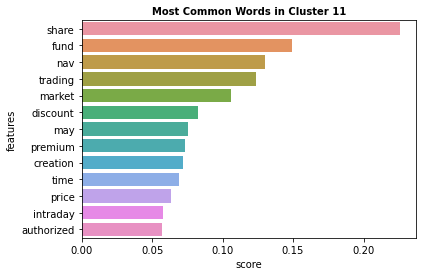

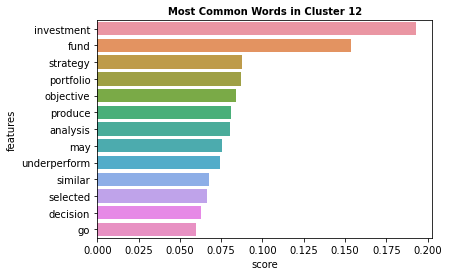

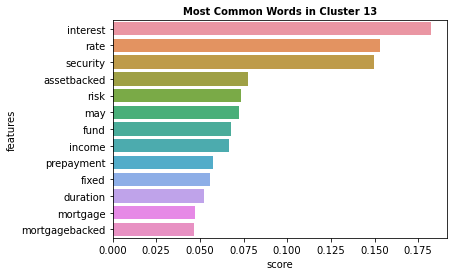

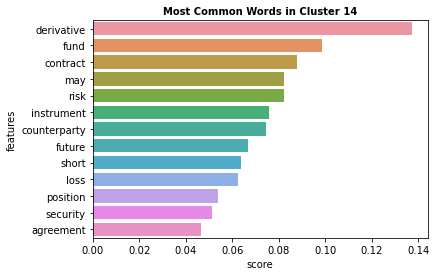

In [27]:
#Plot all clusters' top features
plotWords(dfs, 13)

In [3]:
#Write the labels into original dataframe

labels = kmeans.labels_ 
textdata['labeln'] = labels
textdata.head()

NameError: name 'kmeans' is not defined

In [81]:
#Get counts of all labels per cluster for demonstration

df = textdata.groupby(["labeln","label"]).count()

In [83]:
df.to_csv('labels.csv')

In [31]:
textdata.to_csv('labeled.csv')

Using RNN